In [25]:
import os
import cv2
import yaml
import torch
import shutil
import random
import numpy as np
import subprocess as sp
import supervision as sv
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as f

from sklearn.cluster import KMeans
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
from SoccerNet.Downloader import SoccerNetDownloader
from sports.common.team import TeamClassifier

from help.model.cls_hrnet import get_cls_net
from help.model.cls_hrnet_l import get_cls_net as get_cls_net_l
from help.utils.utils_calib import FramebyFrameCalib
from help.utils.utils_heatmap import get_keypoints_from_heatmap_batch_maxpool, get_keypoints_from_heatmap_batch_maxpool_l, complete_keypoints, coords_to_dict

In [2]:
train_path = '/home/adityapg/work/Sports-Analysis/datasets/train'
test_path = '/home/adityapg/work/Sports-Analysis/datasets/test'
images_path = '/home/adityapg/work/Sports-Analysis/datasets/images'
labels_path = '/home/adityapg/work/Sports-Analysis/datasets/labels'

config_path = '/home/adityapg/work/Sports-Analysis/Player Tracking/config.yaml'
model_path = '/home/adityapg/work/Sports-Analysis/models/yolov10m.pt'
finetune_path = '/home/adityapg/work/Sports-Analysis/Player Tracking/runs/detect/train/weights/best.pt'

# Preprocess

In [ ]:
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="datasets/")
mySoccerNetDownloader.password = "s0cc3rn3t"

mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train", "test"])

In [4]:
def convert(box, width, height):
    x, y, w, h = box
    x, w = x / width, w / width
    y, h = y / height, h / height

    bbox = [x + w/2, y + h/2, w, h]
    return bbox

In [5]:
def make_labels(train_path):
    for name in os.listdir(train_path):
        for file in os.listdir(f'{train_path}/{name}/img1'):
            os.rename(f'{train_path}/{name}/img1/{file}', f'{train_path}/{name}/img1/{name}_{file}')

    for name in os.listdir(train_path):
        label_path = f'{train_path}/{name}/labels'    
        
        if os.path.exists(label_path):
            shutil.rmtree(label_path)
        os.makedirs(label_path)

        width, height = 1, 1
        with open(f'{train_path}/{name}/seqinfo.ini', 'r') as file:
            data = file.readlines()
            for line in data:
                if 'imWidth' in line:
                    width = eval(line.split('=')[1])
                elif 'imHeight' in line:
                    height = eval(line.split('=')[1])

        ball_ids = []
        goalkeeper_ids = []
        referee_ids = []
        with open(f'{train_path}/{name}/gameinfo.ini', 'r') as file:
            data = file.readlines()
            for line in data:
                if 'ball' in line:
                    ball_ids.append(eval(line.split('=')[0].split('_')[1]))
                if 'goalkeeper' in line:
                    goalkeeper_ids.append(eval(line.split('=')[0].split('_')[1]))
                if 'referee' in line:
                    referee_ids.append(eval(line.split('=')[0].split('_')[1]))

        with open(f'{train_path}/{name}/gt/gt.txt', 'r') as file:
            data = file.readlines()
            for line in data:
                line = [eval(i) for i in line.split(',')]
                bbox = convert(line[2:6], width, height)
                
                class_id = 1
                if line[1] in ball_ids:
                    class_id = 0
                elif line[1] in goalkeeper_ids:
                    class_id = 2
                elif line[1] in referee_ids:
                    class_id = 3

                with open(f'{train_path}/{name}/labels/{name}_{line[0]:06d}.txt', 'a') as f:
                    f.write(f'{class_id} {" ".join([str(i) for i in bbox])}\n')

In [6]:
def split(train_path, images_path, labels_path):
    if os.path.exists(images_path):
        shutil.rmtree(images_path)
    os.makedirs(images_path)

    os.makedirs(f'{images_path}/train')
    os.makedirs(f'{images_path}/val')

    if os.path.exists(labels_path):
        shutil.rmtree(labels_path)
    os.makedirs(labels_path)

    os.makedirs(f'{labels_path}/train')
    os.makedirs(f'{labels_path}/val')

    names = []
    for name in os.listdir(train_path):
        names.extend(os.listdir(f'{train_path}/{name}/img1'))

    names = [name.split('.')[0] for name in names]
    random.shuffle(names)
    train = names[:int(0.8*len(names))]

    for name in os.listdir(train_path):
        img_path = f'{train_path}/{name}/img1'
        label_path = f'{train_path}/{name}/labels'

        for file in os.listdir(img_path):
            file = file.split('.')[0]

            if file in train:
                shutil.copy(f'{img_path}/{file}.jpg', f'{images_path}/train/')
                shutil.copy(f'{label_path}/{file}.txt', f'{labels_path}/train/')
            else:
                shutil.copy(f'{img_path}/{file}.jpg', f'{images_path}/val/')
                shutil.copy(f'{label_path}/{file}.txt', f'{labels_path}/val/')

In [7]:
make_labels(train_path)
split(train_path, images_path, labels_path)

In [44]:
model = YOLO(model_path)
model.train(data=config_path, epochs=10, batch=4, amp=False)

Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 5751MiB)
engine/trainer: task=detect, mode=train, model=/home/adityapg/work/Sports-Analysis/models/yolov10m.pt, data=/home/adityapg/work/Sports-Analysis/Player Tracking/config.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning /home/adityapg/work/Sports-Analysis/datasets/labels/train.cache... 34200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34200/34200 [00:00<?, ?it/s]
val: Scanning /home/adityapg/work/Sports-Analysis/datasets/labels/val.cache... 8550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8550/8550 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.72G      2.841      1.329      1.869         74        640: 100%|██████████| 8550/8550 [51:52<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:20<00:00,  7.64it/s]


                   all       8550     146814       0.83      0.721      0.758      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.91G      2.722      1.146      1.834         68        640: 100%|██████████| 8550/8550 [51:25<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:19<00:00,  7.64it/s]


                   all       8550     146814      0.847      0.738      0.774      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       4.9G      2.639      1.097      1.816         67        640: 100%|██████████| 8550/8550 [51:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:19<00:00,  7.64it/s]


                   all       8550     146814      0.853      0.746      0.784      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.91G      2.565      1.061        1.8         77        640: 100%|██████████| 8550/8550 [51:17<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:19<00:00,  7.64it/s]


                   all       8550     146814      0.864      0.748      0.789      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       4.9G      2.504       1.03      1.785         63        640: 100%|██████████| 8550/8550 [51:16<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:20<00:00,  7.64it/s]


                   all       8550     146814      0.883       0.75      0.794      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.92G      2.448          1      1.775         64        640: 100%|██████████| 8550/8550 [51:17<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:20<00:00,  7.63it/s]


                   all       8550     146814       0.88      0.757      0.798      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.89G      2.404     0.9751      1.766         62        640: 100%|██████████| 8550/8550 [51:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:19<00:00,  7.64it/s]


                   all       8550     146814      0.883      0.759      0.802      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       4.9G      2.354     0.9538      1.755         66        640: 100%|██████████| 8550/8550 [51:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:20<00:00,  7.63it/s]


                   all       8550     146814      0.879      0.766      0.806      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.91G      2.303     0.9245      1.747         64        640: 100%|██████████| 8550/8550 [51:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:20<00:00,  7.63it/s]


                   all       8550     146814      0.887      0.766      0.808      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       4.9G      2.248     0.8973      1.736         54        640: 100%|██████████| 8550/8550 [51:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:19<00:00,  7.64it/s]


                   all       8550     146814      0.883      0.771      0.811       0.54

10 epochs completed in 8.953 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 33.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 5751MiB)
YOLOv10m summary (fused): 369 layers, 16,455,016 parameters, 0 gradients, 63.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1069/1069 [02:15<00:00,  7.91it/s]


                   all       8550     146814      0.882      0.771      0.811       0.54
                  ball       8077       8213      0.725      0.221      0.307      0.115
                player       8550     121504      0.946      0.969      0.986      0.703
            goalkeeper       4800       4800      0.931      0.948      0.975      0.666
               referee       7946      12297      0.928      0.945      0.975      0.675
Speed: 0.1ms preprocess, 14.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca4ca26f820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Annotation

In [3]:
transform2 = T.Resize((540, 960))
device = torch.device('cuda')
color_map = {
    'player': (0, 0, 255),
    'ball': (255, 255, 0),
    'referee': (255, 0, 0),
    'goalkeeper': (0, 0, 0)
}


def projection_from_cam_params(final_params_dict):
    cam_params = final_params_dict["cam_params"]
    x_focal_length = cam_params['x_focal_length']
    y_focal_length = cam_params['y_focal_length']
    principal_point = np.array(cam_params['principal_point'])
    position_meters = np.array(cam_params['position_meters'])
    rotation = np.array(cam_params['rotation_matrix'])

    It = np.eye(4)[:-1]
    It[:, -1] = -position_meters
    Q = np.array([[x_focal_length, 0, principal_point[0]],
                  [0, y_focal_length, principal_point[1]],
                  [0, 0, 1]])
    P = Q @ (rotation @ It)

    return P


def inference(cam, frame, model, model_l, kp_threshold, line_threshold):
    frame = Image.fromarray(frame)

    frame = f.to_tensor(frame).float().unsqueeze(0)
    # _, _, h_original, w_original = frame.size()
    frame = frame if frame.size()[-1] == 960 else transform2(frame)
    frame = frame.to(device)
    b, c, h, w = frame.size()
    frame = frame.to(device)

    model.eval()
    model_l.eval()
    model.to(device)
    model_l.to(device)

    with torch.no_grad():
        heatmaps = model(frame)
        heatmaps_l = model_l(frame)

    kp_coords = get_keypoints_from_heatmap_batch_maxpool(heatmaps[:,:-1,:,:])
    line_coords = get_keypoints_from_heatmap_batch_maxpool_l(heatmaps_l[:,:-1,:,:])
    kp_dict = coords_to_dict(kp_coords, threshold=kp_threshold)
    lines_dict = coords_to_dict(line_coords, threshold=line_threshold)
    final_dict = complete_keypoints(kp_dict, lines_dict, w=w, h=h, normalize=True)

    cam.update(final_dict[0])
    final_params_dict = cam.heuristic_voting()

    return final_params_dict


def get_map_point(point, P):
    point = np.linalg.inv(P) @ np.array(point)
    point = point/point[2]
    point[0] += 105/2
    point[1] += 68/2
    return (point[0], point[1])


def project(P, coords):
    pts = coords['coords']
    pts = [get_map_point([(x1+x2)/2, y2,1], P) for x1,_,x2,y2 in pts]

    return pts


def process_input(input, coords, model, model_l, kp_threshold, line_threshold):
    frame_width = input.shape[1]
    frame_height = input.shape[0]
    cam = FramebyFrameCalib(iwidth=frame_width, iheight=frame_height, denormalize=True)

    final_params_dict = inference(cam, input, model, model_l, kp_threshold, line_threshold)

    if final_params_dict is not None:
        P = projection_from_cam_params(final_params_dict)
        # Delete 3rd column of P
        P_reduced = np.array(
            [[P[0][0], P[0][1], P[0][3]],
            [P[1][0], P[1][1], P[1][3]],
            [P[2][0], P[2][1], P[2][3]]]
        )
        pts = project(P_reduced, coords)
    else:
        pts = []

    return pts


def inf_main(input, coords, weights_kp ="help/weights/SV_FT_WC14_kp", weights_line="help/weights/SV_FT_WC14_lines", kp_threshold = 0.1486, line_threshold = 0.3880, device = 'cuda'):
    cfg = yaml.safe_load(open("help/config/hrnetv2_w48.yaml", 'r'))
    cfg_l = yaml.safe_load(open("help/config/hrnetv2_w48_l.yaml", 'r'))

    loaded_state = torch.load(weights_kp, map_location=device)
    model = get_cls_net(cfg)
    model.load_state_dict(loaded_state)
    model.to(device)
    model.eval()

    loaded_state_l = torch.load(weights_line, map_location=device)
    model_l = get_cls_net_l(cfg_l)
    model_l.load_state_dict(loaded_state_l)
    model_l.to(device)
    model_l.eval()

    pts = process_input(input, coords, model, model_l, kp_threshold, line_threshold)

    return pts

In [ ]:
def make_video(clip_path):
    ffmpeg_path = 'ffmpeg'
    command = [
        ffmpeg_path,
        '-i', f'{clip_path}/img1/%06d.jpg',
        '-r', '25',
        '-y',
        '-v', 'quiet',
        '-c:v', 'libx264',
        f'{clip_path}/out.mp4'
    ]
    sp.run(command)


def resolve_goalkeepers_team_id(players, goalkeepers):
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)


def extract_crops(model, source_video_path, stride, player_id, confidence=0.3):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=stride)

    crops = []
    for frame in frame_generator:
        result = model(frame, conf=confidence, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == player_id]

        crops += [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]

    return crops


def get_player_colour(crops):
    top = [i[i.shape[0]//10 : i.shape[0]//2, :] for i in crops]
    cvrt = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in top]
    # blur = [cv2.GaussianBlur(i, (5, 5), 0) for i in cvrt]
    blur = [cv2.GaussianBlur(image, (111, 111), 0) for image in cvrt]
    edges = [image - blurred for image, blurred in zip(cvrt, blur)]

    player_colours = []
    for i in range(len(edges)):
        img_2d = edges[i].reshape(-1, 3)

        kmeans = KMeans(n_clusters=2, random_state=0).fit(img_2d)
        labels = kmeans.labels_
        clustered_image = labels.reshape(edges[i].shape[0], edges[i].shape[1])

        plt.imshow(clustered_image)
        plt.show()

        corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
        non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        # player_colour = kmeans.cluster_centers_[player_cluster]
        if player_cluster == 0:
            clustered_image = 1 - clustered_image

        foo = cvrt[i][clustered_image == 1]
        player_colour = np.mean(foo, axis=0)

        plt.imshow([[[int(player_colour[0]), int(player_colour[1]), int(player_colour[2])]]])
        plt.show()
        player_colours.append(player_colour)

    return player_colours

def assign_team(player_colours):
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1).fit(player_colours)

    team_ids = []
    for i in player_colours:
        team_ids.append(kmeans.predict(i.reshape(1, -1))[0])
    
    print(team_ids)
    return np.array(team_ids)



def annotate_video(clip_path, out_path, finetune_path, confidence=0.3):
    SOURCE_VIDEO_PATH = clip_path
    TARGET_VIDEO_PATH = out_path
    BALL_ID = 0
    PLAYER_ID = 1
    GOALKEEPER_ID = 2
    REFEREE_ID = 3

    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
        thickness=2
    )
    label_annotator = sv.LabelAnnotator(
        color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
        text_color=sv.Color.from_hex('#000000'),
        text_position=sv.Position.BOTTOM_CENTER,
    )
    triangle_annotator = sv.TriangleAnnotator(
        color=sv.Color.from_hex('#FFD700'),
        base=20, height=17
    )

    tracker = sv.ByteTrack()
    tracker.reset()

    video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
    video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info)
    STRIDE = video_info.fps

    model = YOLO(finetune_path)
    
    # crops = extract_crops(model, SOURCE_VIDEO_PATH, STRIDE, PLAYER_ID, confidence=confidence)
    team_classifier = TeamClassifier(device='cuda')
    # team_classifier.fit(crops)

    frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

    with video_sink:
        for frame in tqdm(frame_generator, total=video_info.total_frames):
            result = model(frame, conf=confidence, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = detections.with_nms(threshold=0.5, class_agnostic=True)
            detections = tracker.update_with_detections(detections)

            # labels = [f'#{tracker_id}' for tracker_id in detections.tracker_id]

            # coords = detections.xyxy
            # class_names = detections.data['class_name']
            # arr = {'coords': coords, 'labels': class_names}
            # pts = inf_main(frame, arr)

            # print(list(zip(pts, class_names, labels)))
            
            ball_detections = detections[detections.class_id == BALL_ID]
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

            all_detections = detections[detections.class_id != BALL_ID]

            goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
            players_detections = all_detections[all_detections.class_id == PLAYER_ID]
            referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

            players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
            # players_detections.class_id = team_classifier.predict(players_crops)
            player_colours = get_player_colour(players_crops)
            players_detections.class_id = assign_team(player_colours)
            
            goalkeeper_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeeper_detections)

            referees_detections.class_id -= 1

            all_detections = sv.Detections.merge([players_detections, goalkeeper_detections, referees_detections])

            labels = [f'#{tracker_id}' for tracker_id in all_detections.tracker_id]

            all_detections.class_id = all_detections.class_id.astype(int)

            annotated_frame = frame.copy()
            annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
            annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels)
            annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

            video_sink.write_frame(annotated_frame)
            break

  0%|          | 0/351 [00:00<?, ?it/s]

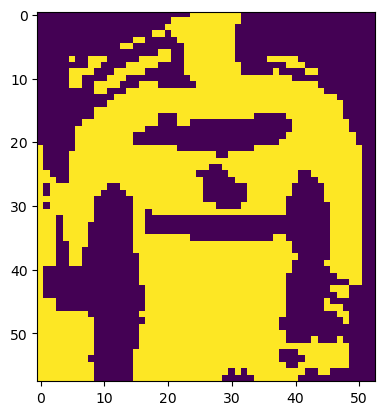

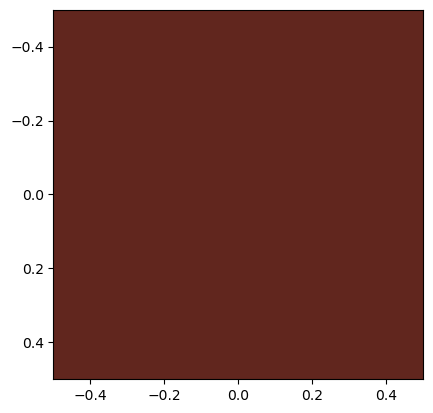

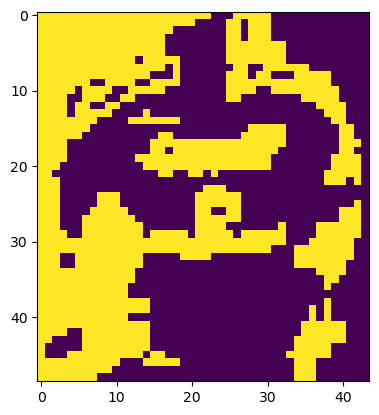

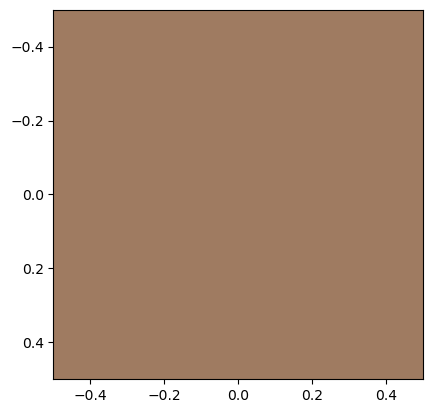

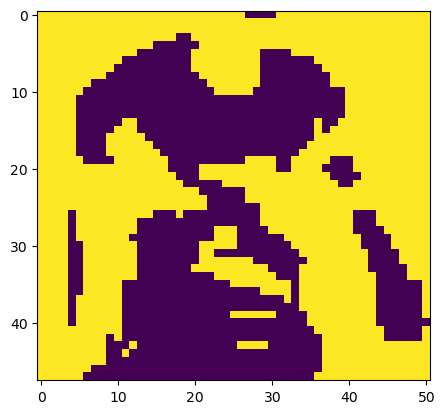

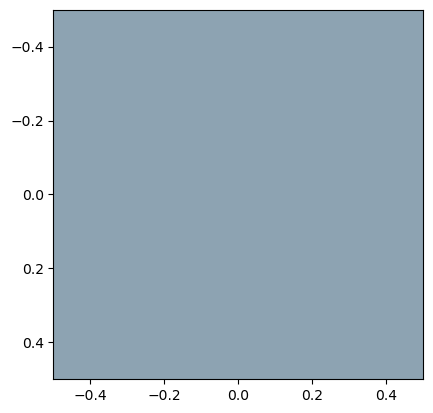

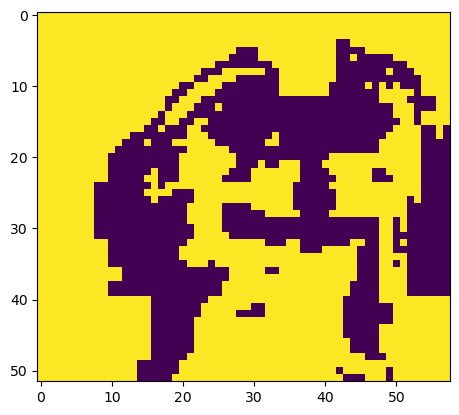

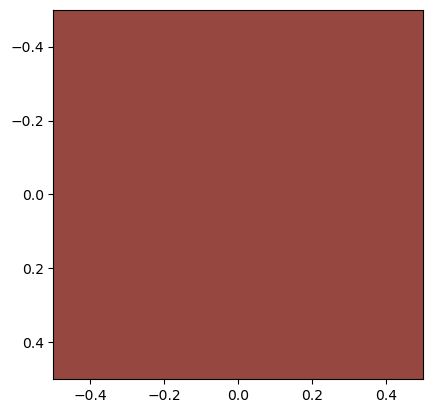

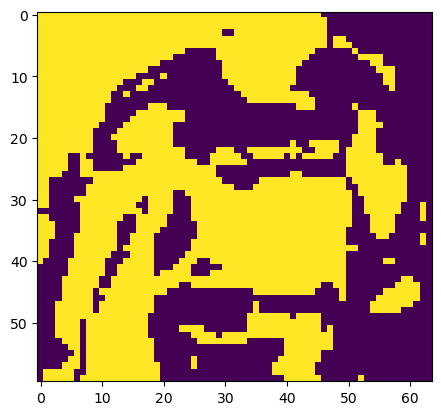

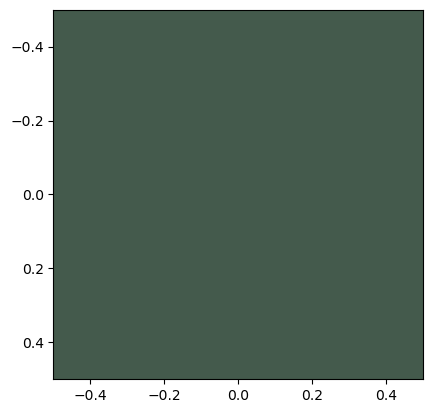

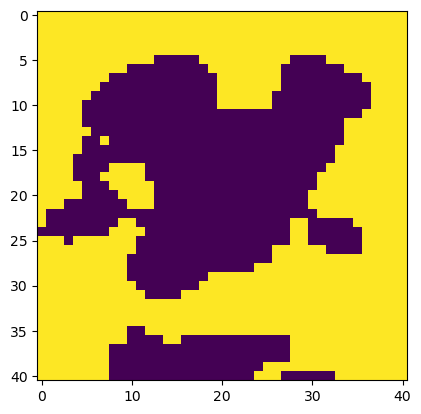

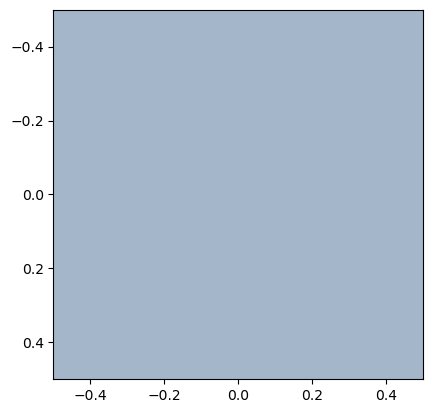

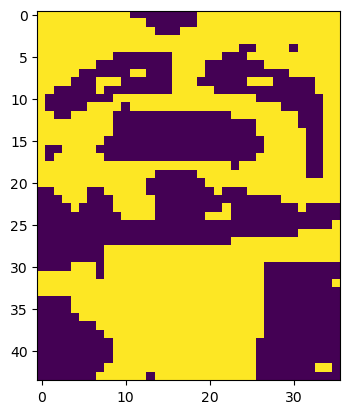

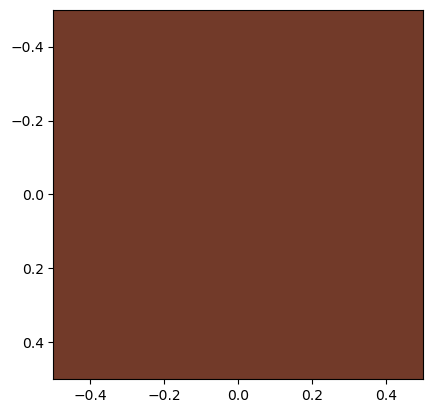

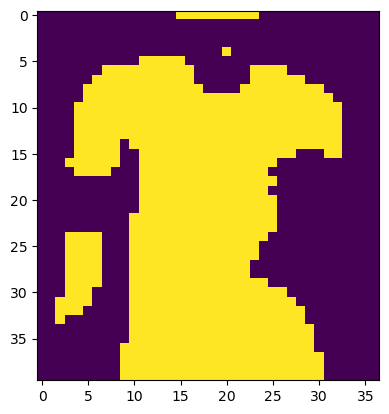

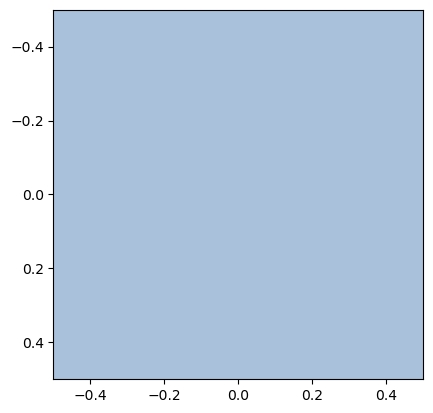

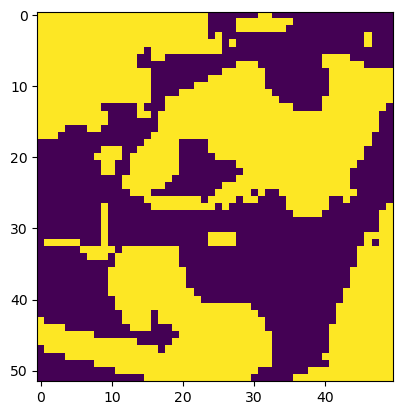

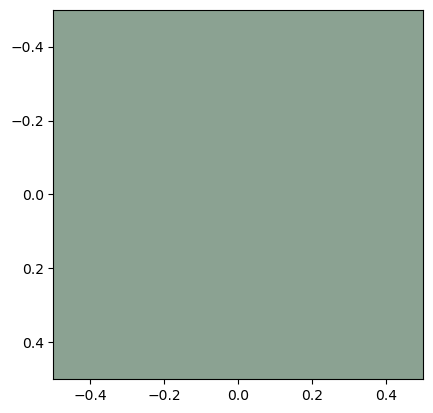

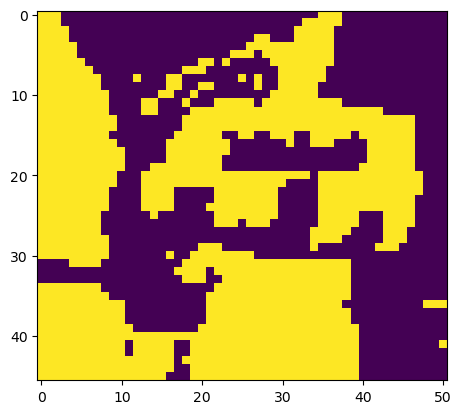

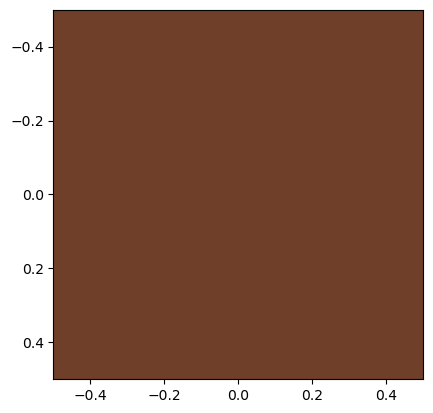

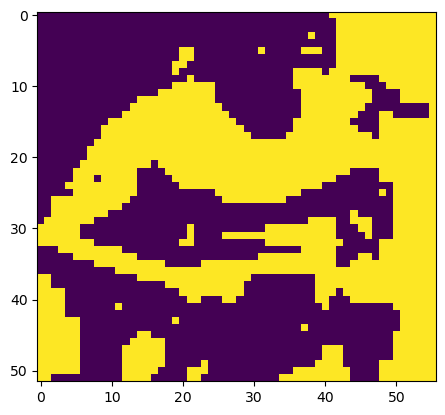

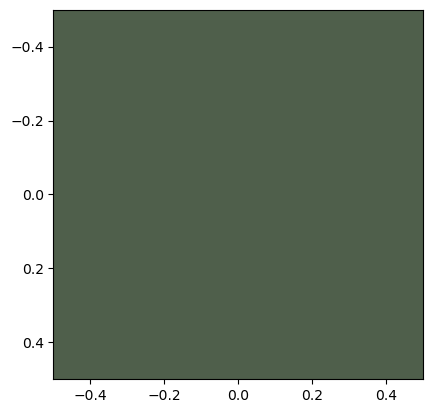

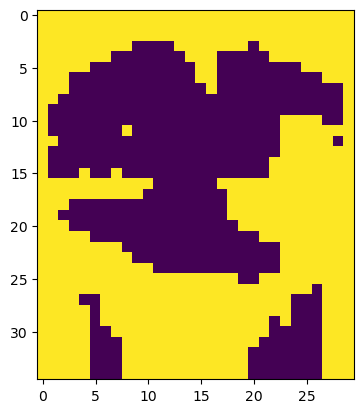

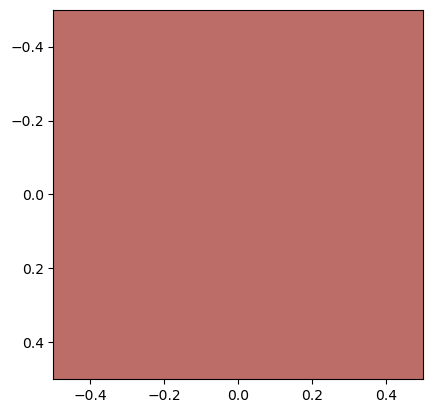

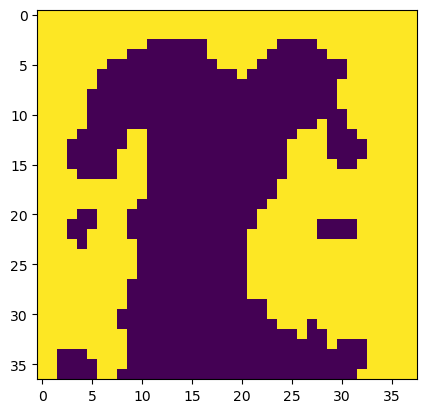

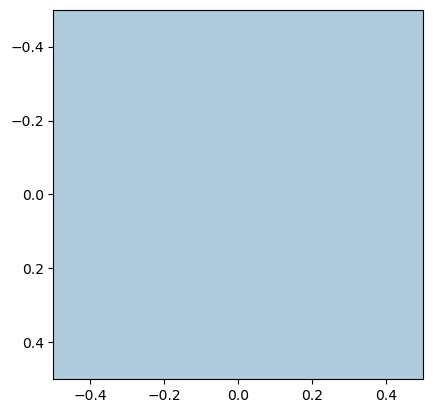

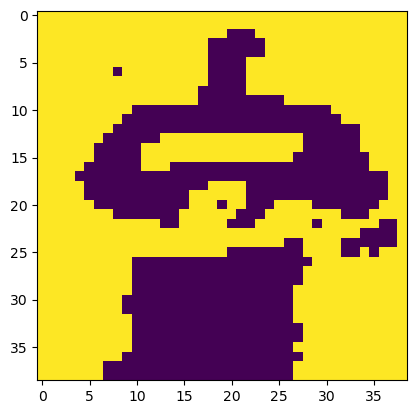

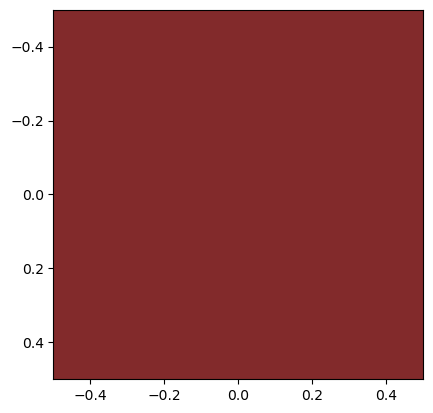

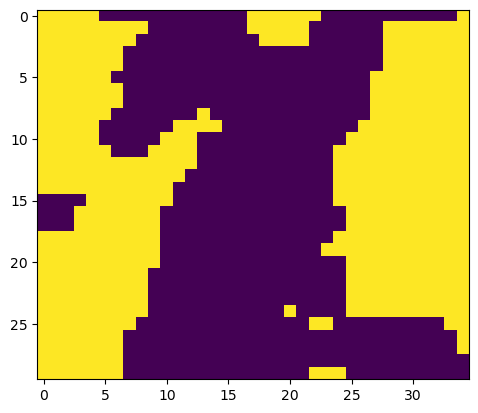

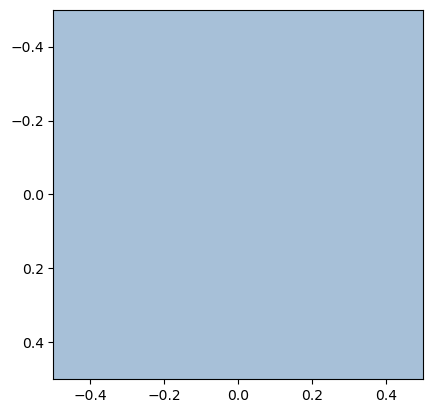

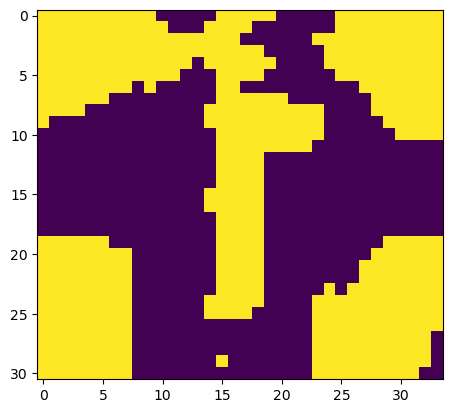

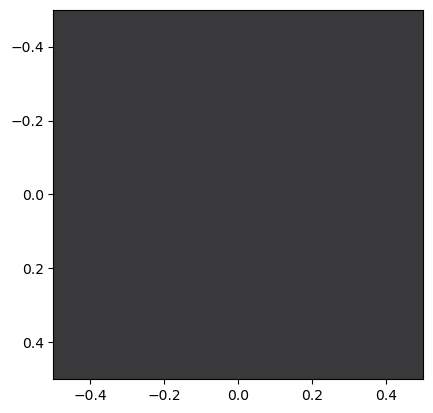

  0%|          | 0/351 [00:01<?, ?it/s]

[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]


In [134]:
clip_path = f'{test_path}/f.mp4'
out_path = f'{test_path}/f_output.mp4'

# make_video(clip_path)
annotate_video(clip_path, out_path, finetune_path, confidence=0.5)